# Equvariant Neural Networks

The previous chapter {doc}`data` discussed data transformation and network architecture decisions that can be made to make a neural network equivariant with respect to translation, rotation, and permutations. However, those ideas limit the expressibility of our networks and are constructed ad-hoc. Now we will take a more systematic approach to defining equivariances and prove that there is only one layer type that can preserve a given equivariance. The result of this section will be layers that can be equivariant with respect to any transform, even for more esoteric cases like points on a sphere or mirror operations. To achieve this, we will need tools from group theory, representation theory, harmonic analysis, and deep learning.


## Do you need equivariance?

Before we get too far, let me first try to talk you out of equivariant networks. The math required is advanced, especially because the theory of these is still in flux. There are three papers in the last two years that propose a general theory for equivariant networks and they each take a different approach. It is also easy to make mistakes in implementations due to the complexity of the methods. You also must do implementations (as of 2020) because there are no efficient general implementations for equivariant networks. You will also find that equivariant networks do not beat state of the art models on many of the tasks they're design for. Training and testing augmentation are powerful methods for many problems that are easy to implement. You can also do data transformations or specific parameter sharing to avoid equivariant networks. So why would you study this chapter? I think these ideas are important and incorporating the equivariant layers into other network architectures (Dimenet?) can dramatically reduce parameter numbers and training efficiency.



### Outline

We have to lay some mathematical foundations before we can grasp the equations and details of equivariant networks. We'll start with a brief overview of group theory so we can define the principle of equivariance generally. Then we'll visit representation theory to see how to encode groups into matrices. Then we'll show how any equivariance can be enforced in a neural network via a generalization of convolutions. Then we'll see how these convolutions can be more easily represented using the generalization of Fourier transforms. Finally, we'll see some of the special details when looking at equivariances of permutations. Throughout this chapter we'll see three examples that capture some of the different settings. Remember, that I am a chemical engineer so that some of this chapter will probably have reckless math, incomplete definitions, and implied assumptions about functions (e.g., smooth, integrable). 

## Group Theory

A group is a general object in mathematics. A group is a set of elements that can be combined in a binary operation whose output is another member of the group. The most common example are the integers. If you combine two integers in a binary operations, the output is another integer. Of course, it depends on the operation ($1 \div 2$ does not give an integer), so specifically consider addition. Integers are not the example we care about though. We're interested in groups of **transformations** that move points in a space. Operations like rotation, scaling, mirroring, or translating of single points. As you read about groups here, remember that the elements of the groups are *not* numbers or points. The group elements are transformations that act on points in the space. Notice I'm being a bit nebulous on what the space is for now. Let's first define a group: 

```{admonition} Group Definition
A group $G$ is a set of elements (e.g., $\{a, b, c, i, e\}$) equipped with a binary operation ($a\cdot{}b = c$) whose output is another group element and the following conditions are satisfied:

1. **Closure** The output of the binary operation is always a member of the group
2. **Associativity** $(a\cdot{}b)\cdot{}c = a\cdot{}(b\cdot{}c)$
3. **Identity** There is a single identity element $e$ such that $ex = x \forall x \in G$
4. **Inverse** There exists exactly one inverse element $i$ for each $x$ such that $xi = e$
```

This is quite a bit of nice structure. We always have an inverse available and applying the binary operations never accidentally leaves our group. One important property that is missing from this list is **commutativity**. In general, a group is not commutative so that $a\cdot{}b \neq b\cdot{}a$. If the group does have this extra property, we call the group **abelian**. Another detail is how big the set is. It can indeed be infinite, which is why the integers or all possible rotations of a sphere can be represented as a group. One notational convenience we'll make is that the "binary operation" $\cdot{}$ will just be referred to as multiplication. The number of elements in a group $|G|$ is known as the **order**.

```{margin}
If you multiply two transforms $a\cdot{}b$, we always apply $b$ first and then $a$. This is important to remember for non-commutative groups (non-abelian). 
```

Let's introduce our three example groups that we'll refer to throughout this chapter.


### ⬡ Finite Group $Z_6$ 

The first group is about rotations of a hexagon {glue:}`hex-6`. Our basic group member will be rotating the hexagon enough to shift all the vertices: {glue:}`hex-0` $\rightarrow$ {glue:}`hex-1`. Notice I've colored the vertices and added a line so we can easily distinguish the orientation of the hexagon. Remember the hexagon, its colors, and if it is actually symmetry have nothing to do with the group. *The group elements are transformations we apply to the hexagon*.

Our group must contain our rotation transformation $r$ and the identity: $\{e, r\}$. This set is not closed though: rotating twice $r\cdot{}r$ {glue:}`hex-0` $\rightarrow$ {glue:}`hex-1` $\rightarrow$ {glue:}`hex-2` gives a new group element $r^2$. To close the group we need to have $\{e, r, r^2, r^3, r^4, r^5\}$. 

Is this closed? Consider rotating twice and then five times $r^2\cdot{}r^5$ {glue:}`hex-0` $\rightarrow$ {glue:}`hex-2` $\rightarrow$ {glue:}`hex-1` You can see that this is the same as $r$, so $r^2\cdot{}r^5 = r$. What about the inverses element? The inverse of $r$ is $r^5$. $r\cdot{}r^5 = e$. You can indeed see that each element has an inverse ($e$ is its own inverse).

In general, we can write out the group as a multiplication table that conveys all group elements and defines the output of all binary outputs:

$$
\begin{array}{l|cccccr}
& e & r & r^2 & r^3 & r^4 & r^5\\
\hline
e & e & r & r^2 & r^3 & r^4 & r^5\\
r & r & r^2 & r^3 & r^4 & r^5 & e\\
r^2 & r^2 & r^3 & r^4 & r^5 & e & r\\
r^3 & r^3 & r^4 & r^5 & e & r & r^2\\
r^4 & r^4 & r^5 & e & r & r^2 & r^3\\
r^5 & r^5 & e & r & r^2 & r^3 & r^4\\
\end{array}
$$

You can also see that the group is abelian (commutative). For example, $r\cdot{}r^3 = r^3\cdot{}r$. 

This group is an example of a **cyclic group** and is isomorphic (same transofmrations, but operates on different objects) to integers modulo 6. Meaning, you could view rotation $r^n$ as operating on integers $(x + n) \textrm{mod}\, 6$. Cyclic groups are written as $Z_n$, so this group is $Z_6$. 


### ▩ Locally Compact p4m

The second group contains translation, 90° rotations, and  horizontal/vertical mirroring. We're now operating on real numbers $x,y$, so we're in $\mathbb{R}^2$. Let's ignore the translation for now and just consider mirroring ($s$) and rotation by 90° ($r$) about the origin. What powers of $r$ and $s$ do we need to have a closed group? Considering rotations alone first, like last time we should only need up to $r^3$. Here are the rotations visually: {glue:}`quad-0-0`, {glue:}`quad-1-0`, {glue:}`quad-2-0`, {glue:}`quad-3-0` What about mirroring on horizontal/vertical? Mirroring along the horizontal axis: {glue:}`quad-0-0` $\rightarrow$ {glue:}`quad-2-1` is actually the same as rotating twice and then mirroring along the vertical. In fact, you only need to have mirroing along one axis. We'll choose the vertical axis by convention and denote that as $s$.

Is this closed with $\{e, r, r^2, r^3, s\}$? Visually we have  {glue:}`quad-0-0`, {glue:}`quad-1-0`, {glue:}`quad-2-0`, {glue:}`quad-3-0`, {glue:}`quad-0-1`? No. Consider $r^2\cdot{}s$ {glue:}`quad-0-0` $\rightarrow$ {glue:}`quad-0-1` $\rightarrow$ {glue:}`quad-2-1` which is not an element. To close the group, we need $\{e, r, r^2, r^3, s, rs, r^2s, r^3s\}$. The multiplication table (which defines the elements too) is:

$$
\begin{array}{l|cccccccr}
& e & r & r^2 & r^3 & s & rs & r^2s & r^3s\\
\hline
e & e & r & r^2 & r^3 & s & rs & rs^2 & rs^3\\
r & r & r^2 & r^3 & e & rs & r^2s & r^3s & s\\
r^2 & r^3 & e & r & r^2 & r^2s & r^3s & s & rs\\
r^3 & e & r & r^2 & r^3 & r^3s & s & rs & r^2s\\
s & s & r^3s & r^2s & rs & e & r^3 & r^2 & r\\
rs & rs & s & r^3s & r^2s & r & e & r^3 & r^2\\
r^2s & r^2s & rs & s & r^3s & r^2 & r & e & r^3\\
r^3s & r^3s & r^2s & rs & s & r^3 & r^2 & r & e\\
\end{array}
$$

As you can see from the  table, the group is closed. Remember, elements like $rs$ are not a binary operation. They are group elements. We can also see that the group is not commutative. $r\cdot{}s$ is {glue:}`quad-0-0` $\rightarrow$ {glue:}`quad-0-1` $\rightarrow$ {glue:}`quad-1-1`, so $r\cdot{}s = rs$ as expected. However, $s\cdot{}r$ is {glue:}`quad-0-0` $\rightarrow$ {glue:}`quad-1-0` $\rightarrow$ {glue:}`quad-3-1`, which is the group element $r^3s$.

We can also read the inverses off the table. For example, the inverse of $r$ is the column which gives the identity element: $r^3$. This group is known as the dihedral group 4 $D_4$. It has order 8. 

Now consider the translation group elements. For simplicity, let's only consider integer translations. We can label them as $t_{w,h}$. So $t_{3,4}$ means translate by $x + 3$ and $y + 4$. Is this a proper group? Certainly it associative, there is an identity $t_{0,0}$ and an inverse for each element $t_{-x, -y}$. What about closure? Yes, since translating twice is equivalent to one larger translation: $t_{w,h}\cdot{}t_{w', h'} = t_{w + w', h + h'}$. 

What about when we combine with our other elements from the $D_4$ group? Consider the product $r\cdot{}t_{3,4}$. This means translating by $(3,4)$ and then rotating by 90° about the origin. If you consider this acting on a single point $(0,0)$, you could get $(0,0) \rightarrow (3,4) \rightarrow (-3,4)$. What element of our group would this represent? At first it seems like it could be $t_{-3,4}$. However, $t_{-3,4}$ would only work specifically for starting at $(0,0)$. If you started at $(1,1)$, you would get to $(-4,5)$ with $r\cdot{}t_{3,4}$ and $(-2,5)$ with $t_{-3,4}$. To be correct for *any point*, we need a different group element. So the product $r\cdot{}t_{3,4}$ actually cannot be a product but instead must be a group element. In fact, our new combined group is just going to be $ab$ where $a$ is an element from $D_4$ and $b$ is a translation. Thus $r\cdot{}t_{3,4} = rt_{3,4}$. 

Combing these two groups, the translation and $D_4$, is an example of a **semidirect product**. A semidirect product just means that we create a new group by combining all possible group elements. There is some machinery for this, like the identity element in our new group is something like $et_{0,0}$, and it has some other structure. It is called semidirect, instead of direct, because the $D_4$ group is non-abelian and thus in the semidirect product we need to be careful about the order of operations. To be clear, we can only have a semidirect product when one group is normal (basically abelian) and the translation group is the normal group. This semidirect product group is called p4m.

Below, is an optional section that formalizes the idea of combining these two groups into one larger group.


```{admonition} Normal Subgroup
A normal subgroup is a group of elements $n$ from the group $G$ called $N$. Each $n \in N$ should have the property that $g\cdot{}n\cdot{}g^{-1}$ gives an element in $N$ for any $g$. This does not mean $g\cdot{}ng^{-1} = n$, but instead that $g\cdot{}ng^{-1} = n'$ where $n'$ is some other element in $N$. 
```

For example, in p4m the translations form a normal group. Rotating, translating, then doing the inverse of the rotation is equivalent to some translation. Notice that $D_4$ is not a normal subgroup of p4m. If you do an inverse translation, rotate, then do a translation you may not have something equivalent to a rotation. It may be strange that we're talking about the group p4m when we haven't yet described how it's defined (identity, inverse, binary op). We'll do that with the semidirect product and then we could go back and verify that the translations are a normal subgroup more rigorously. I do not know the exact connection, but it seems that normal subgroups are typically abelian. 

```{admonition} Semidirect Product
Given a normal subgroup of $G$ called $N$ and a subrgoup $H$, we can define $G$ using the semidirect product. Each element in $G$ is a tuple of two elements in $N, H$ written as $(n, h)$. The identity is $(e_n, e_h)$ and the binary operation is:

\begin{equation}
(n_1, h_1) \cdot (n_2, h_2) = (n_1\cdot\phi(h_1)(n_1), h_1\cdot{}h_2)
\end{equation}

where $\phi(h)(n)$ is the conjugation of $n$ $\phi(h)(n) = h\cdot{}n\cdot{}h^{-1}$. When a transform $(n,h)$ is applied, we follow the normal convention that $h$ is applied first followed by $n$. 
```

One consequence of this definition is that if you have a group element $(n,h)$ but want to instead apply $n$ first (instead of $h$), you can use the binary operation:

\begin{equation}
(e_n, h) \cdot (n, e_h) = (e_n\cdot\phi(h)(n), h\cdot{}e_h) = (\phi(h)(n), h)
\begin{equation}

so $\phi(h)(n)$ somehow captures the effect of switching the order applying elements from $H$ and $N$. In our case, this means swapping the order of rotation/mirroring and translation. 

To show what effect the semidirect product has in p4m, we can clean-up our example above about $r\cdot{}t_{3,4}$. We should write the first element of this binary product $r$ as a tuple of group elements: one from the $D_4$ and one from the translations. Since there is no translation for $r$, we use the identity. Thus we write $r$ as $(t_{0,0}, r)$ in our semidirect product group p4m. Note that the normal subgroup comes first (applied last) by convention. Similarly, $t_{3,4}$ is written as $(t_{3,4}, e)$. Our equation becomes:

$$
(t_{0,0}, r)\cdot(t_{3,4}, e) = (t_{0,0}\cdot\phi(r)(t_{3,4}), r\cdot{}e) = (t_{0,0}\cdot\phi(r)(t_{3,4}), r)
$$

where $\phi$ is the automorphism that distinguishes a semidirect product from a direct product. The direct product has $\phi(h)(n) = n$ so that the binary operation for the direct product group is just the element-wise binary products. $\phi(h)(n) = hnh^{-1}$ for semidirect products. In our equation, this means $\phi(r)(t_{3,4}) = r\cdot{}t_{3,4}\cdot{}r^3$. Substituting this and using the fact that both groups have the same binary operation (matrix multiplication, as we'll see shortly):

$$
(t_{3,4}\phi(r)(t_{3,4}), r) = (r\cdot{}t_{3,4}\cdot{}r^3, r) = r\cdot{}t_{3,4}\cdot{}r^3\cdot r = r\cdot{}t_{3,4}
$$

Thus we've proved that translating by $3,4$ followed by rotating can be expressed as $r\cdot{}t_{3,4}$, which seems like a lot of work for an obvious result. 



###  ⚽ SO(3) Lie Group

SO(3) is one of the most difficult groups to work with but is critical for analyzing 3D point clouds like trajectories. SO(3) is the group of all rotations about the origin in 3D. The group is non-abelian because rotations in 3D are not commutative. The group order is infinite, because you can rotate in this group by any angle (or sets of angles). If you are interested in allowing translations, you can use SE(3) which is the semidirect product of SO(3) and the translation group (like p4m), which is a normal subgroup. 

The SO(3) name is a bit strange. (3) is the dimension. SO stands for "special orthogonal" which is an attribute of the $3\times 3$ matrices that represent rotations in 3D. One detail is that since we're rotating (no scale or translation) *our points will all be on a sphere*. We cannot move the radius. By convention then we'll have a radius 1. We'll take more about representing these transformations in a moment. 


### Groups on Spaces

We've defined transforms and their relationships to one another via group theory. Now we need to actually connect the transforms to a space. It is helpful to think about the space as Euclidean with a concept of distance and coordinates, but we'll see that this is not required. Our space could be vertices on a graph or integers or classes. There are *some* requirements though. The first is that our space must be **homogeneous**. Homogeneous means that from any point in our space $x$ we can reach any other point with a transform $g$ from our group $G$. The second requirement is that if our group is infinite, the space must **compact**. Compactness is a concept from topology and essentially means that the space is smooth and differentiable. This is true of most spaces we'll see in chemistry or materials science, except there may be issues at poles on a sphere or other singular points. This doesn't matter for finite groups, so we can use non-compact spaces like vertices on a graph for finite groups. If the group transforms are further smooth and have smooth inverses, the group (and associated space) are called a **lie group**. 

```{margin}
The lie group definition is a side-note, it has nothing to do with our analysis.
```

```{tabbed} ⬡ Finite Group $Z_6$ 

The space is homogeneous because our group includes "compound" rotations like $r^4$. This is a finite group, so we do not require the space to be compact. 

```

```{tabbed} ▩ Locally Compact $p4m$

The space is homogeneous since we can use a translation to get to any other point. The space is locally compact because we are in 2D Euclidean geometry. It is not a lie group, because the dihedral operations (rotate/mirror) are not smooth. Or at least I don't think so, I don't know enough about topology. 

```

```{tabbed} ⚽ SO(3) Lie Group $SO(3)$

The space is homogeneous because we restrict ourselves to being on the sphere. The space is locally compact because we are in 3D Euclidean geometry. This is a lie group because the transformations are continuous and smooth. 

```

This may seem like a ton of work. We could have just started with $xyz$ coordinates and rotation matrices. Please continue to wait though, we're about to see something incredible.

## Equivariance Definition

You should be thinking now about how we can define equivariance using our new groups. That's where we're headed. We need to do a bit of work now to "lift" neural networks and our features into the framework we're building. First, in {doc}`data` we defined our features as being composed of tuples $(\vec{r}_i, \vec{x}_i)$ where $\vec{r}_i$ is a spatial point and $\vec{x}_i$ are the features at that point. Let's now view these input data as functions, defined as $f(\vec{r}) = \vec{x}$ and assume if a point $\vec{r}'$ isn't in our training data then $f(\vec{r}') = \vec{0}$. More formally, our training data is a function $f:\mathcal{X} \rightarrow \mathbb{R}^n$ that maps from our homogeneous space $\mathcal{x}$ to real vector (or complex vectors) of dimension $n$. 

We have promoted our data into a function and now a neural network can no longer be just function since its input is a function. Our neural network will be also promoted to an **linear map**, which has an input of a function and an output of a function. Formally, our network $psi: f(\mathcal{X}) \rightarrow f'(\mathcal{X})$. Notice the input and output spaces of the functions should be the same (we cannot switch from 2D to 3D). Linear maps are also called **operators**, depending on which branch of mathematics you're in.

The last piece of equivariance is to promote our group elements, which transform points, to work on functions.

```{admonition} G-Function Transform Definition
An element $g$ of group $G$ on the homogeneous space $\mathcal{X}$ can act on a function $f:\mathcal{X}\rightarrow \mathbb{R}^n$ via the group transform linear map $\mathbb{T}_g: f(\mathcal{X}) \rightarrow f'(mathcal{X})$ defined as 

\begin{equation}
f'(gx) = f(x) \Rightarrow f'(x) = f(g^{-1}x)
\end{equation}
```

This definition takes a moment to think about. Consider a translation of an image. You want to move an image to the left by 10 pixels, so $g = t_{10,0}$. The image is defined by the function $f(x,y) = (r, g, b)$, where $r,g,b$ is the color. We want $T_g f(x, y)$. Without knowing about groups, you can intuit that translating can be done by creating a new function $f'(x', y') = f(x - 10, y)$. Notice that the inverse of $g^{-1} = t_{-10, 0}$ acts on the points, not $g$. Recall that a group requires there to be an inverse for any group element.

Now we have all the pieces to define an equivariant neural network:

```{admonition} Equivariant Neural Network Definition
Given a group $G$ on a homogeneous space $\mathcal{X}$, a G-covariant neural network is linear map $\psi: f(\mathcal{X}) \rightarrow f'(\mathcal{X})$ that has the property{cite}`kondor2018generalization`:

\begin{equation}
\psi\left[\mathbb{T}_g f(x)\right] = \mathbb{T}_g'\psi\left[f(x)\right] \forall f
\end{equation}

If $g = g'$ the $\psi$ is G-equivariant neural network. If $g = g' = e$, the identity, then $\psi$ is a G-invariant neural network.
```

Note **covariant** is a rarely used term; I only include it to distinguish between the general case of $g \neq g'$ and the much more common $g = g'$ equivariant case. The definition means that we get the same output if we transform the input function to the neural network or transform the output (in the equivariant case). In a specific example, if we rotate the input by 90 degrees, that's the same result as rotating the output by 90 degrees. Take a moment to ensure that matches your idea of what equivariance means. After all this math, we've generalized equivariance to arbitrary spaces and groups.

Intro video: https://www.youtube.com/watch?v=mH0oCDa74tE

Convolutions are only way to go: https://arxiv.org/abs/1806.09231

homogenuous -> you can reach any point with a group. 

best theory (I think) https://arxiv.org/pdf/1802.03690.pdf
similar but with fiber bundles/cosets -> https://arxiv.org/pdf/1811.02017.pdf

induced action -> group element acting on function. Induced space -> space of that (?)


some people say covariant -> group element on input != group element on output

Let's start with G-CNN which I'm having trouble understanding:

Presentation on locally compact groups -> https://galton.uchicago.edu/mart/slides/Kondor_Fourier.pdf

commutative -> representations are complex scalars (FFT is easy). Called LCA (locally compact abelian)     

$$
[f * \psi](g) = \frac{1}{|G|}\sum_{x}
$$

## Outline

Maybe start with finite group, conclude with G-CNN 

Then move to compact groups

then move to permutations

1. Finite Groups and use molecular structure example  https://en.wikipedia.org/wiki/Molecular_symmetry
2. Representations, irreps -- finding them https://www.jstor.org/stable/2004848?seq=1#metadata_info_tab_contents, https://en.wikipedia.org/wiki/Group_representation, character tables - https://www.chem.uci.edu/~lawm/10-2.pdf package: https://gemmi.readthedocs.io/en/latest/symmetry.html#operations - does not include permutation symmetry
3. functions on them -> an image is a function, molecular coordiates are a function, we're learning a function (?)Does that mean layers are operators? Guess so
4. define equivariance 
5. equivariant neuron - Show group CNN first, then Kondor construction
6. examples
7. survey of field

G-CNN - easy for discrete groups. http://proceedings.mlr.press/v48/cohenc16.pdf
could use for all point groups too - depends on number of group elements. 

DeepSets - https://proceedings.neurips.cc/paper/2017/file/f22e4747da1aa27e363d86d40ff442fe-Paper.pdf
equivariant strategy for networks. This defines them using convolutions - https://arxiv.org/pdf/2004.03990.pdf. Here is the hierarchical variant: https://proceedings.neurips.cc//paper_files/paper/2020/hash/9efb1a59d7b58e69996cf0e32cb71098-Abstract.html - they use MLPs with weight sharing. Is that equivalent to group convolutions? Average over groups strategy -> equation 44 in https://arxiv.org/pdf/2004.05154.pdf. Maybe average over groups = convolution (aka correlation). Yes, it does. However, you do not have to average. You can keep each independent component. The averaging comes from the pooling. Averaging moves to a coset (removing a part of the group) and moves you to a quoteint space (see 6.5 in G-CNN ppaer). 

Icosohedron convs enforce weight sharing in their convolutions - https://arxiv.org/pdf/1902.04615.pdf

The Clepsh-Gordon approach doesn't use a convolution, but instead a product in spectral (fourier) space. 

Fiber bundles and fields intro. Proves convolutions are only way to do it. 

https://arxiv.org/pdf/1811.02017.pdf

Notation - you can refer to the irreducible representations of SO3 (momentum numbers, l = ) as fragments

ok modern permutation invariant -> https://arxiv.org/pdf/2004.03990.pdf. Maybe not that interesting (second order permutations are interesting), but reconciles the locally compact groups being fourier convolutions with permutations. 

Can approximate convolutions with quadrature (MC integration) https://arxiv.org/pdf/2002.12880.pdf instead of using Fourier Space

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e1bc2', '#AAAAAA']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)

0 0


0 1


1 0


1 1


2 0


2 1


3 0


3 1


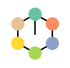

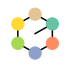

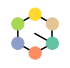

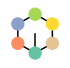

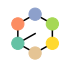

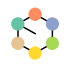

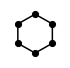

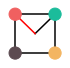

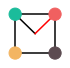

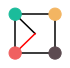

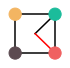

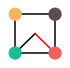

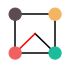

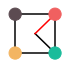

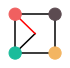

In [39]:
from myst_nb import glue

def hexico(rot):
    cmap = plt.get_cmap('Set2')        
    colors = [cmap(i / 6) for i in range(6)]
    points = np.array([(0,1), (0.5 * np.sqrt(3), 0.5), (0.5 * np.sqrt(3), -0.5), (0, -1), (-0.5 * np.sqrt(3), -0.5), (-0.5 * np.sqrt(3), 0.5)])
    # wrap the points
    index = [(i + rot) % 6 for i in range(6)]
    points = points[index]
    plt.figure(figsize=(1, 1))        
    if rot == 6:
        plt.scatter(points[:,0], points[:,1], marker='.', color='black', s=150)
    else:
        plt.scatter(points[:,0], points[:,1], marker='o', c=colors, s=150)
        plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0)    
        
    plt.plot(points[:, 0], points[:, 1], color='black', zorder=0)
    plt.plot([points[-1, 0], points[0, 0]],  [points[-1, 1], points[0, 1]], color='black', zorder=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1.4, 1.4)
    plt.ylim(-1.4, 1.4)    
    for s in plt.gca().spines.values():
        s.set_visible(False)
    glue(f'hex-{rot}', plt.gcf(), display=False)
for i in range(7):
    hexico(i)
    
def quad(rot, mirror):
    colors = color_cycle[:4]
    points = np.array([(1, 1), (-1, 1), (-1, -1), (1, -1)])
    if mirror:
        points[:,0] *= -1
    # wrap the points
    index = [(i + rot) % 4 for i in range(4)]
    points = points[index]
    plt.figure(figsize=(1, 1))        
    plt.scatter(points[:,0], points[:,1], marker='o', c=colors, s=150)
    plt.plot([0, points[0,0]], [0, points[0, 1]], color='black', zorder=0)    
        
    plt.plot(points[:, 0], points[:, 1], color='black', zorder=0)
    plt.plot([points[-1, 0], points[0, 0]],  [points[-1, 1], points[0, 1]], color='C0', zorder=0)
    plt.plot([0, points[1, 0]],  [0, points[1, 1]], linestyle='-', color='C1', zorder=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(-1.4, 1.4)
    plt.ylim(-1.4, 1.4)    
    for s in plt.gca().spines.values():
        s.set_visible(False)
    print(rot, mirror)
    glue(f'quad-{rot}-{mirror}', plt.gcf(), display=False)
for i in range(4):
    for j in range(2):
        quad(i, j)